In [1]:
import os
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scanorama
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

## Attempt to classify cell types
See Scanpy-analysis.ipynb beforehand.

https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_06_celltype.html

In [61]:
adata = anndata.read("../data/adata.h5ad") # does not have doublets and dead cells
#adata_nofilter = anndata.read("../data/adata_nofilter.h5ad") # has doublets and dead cells

In [62]:
# Read the reference data

adata_ref = sc.datasets.pbmc3k_processed() 
adata_ref.obs['sample']='pbmc3k'

print(adata_ref.shape)
adata_ref.obs

(2638, 1838)


,n_genes,percent_mito,n_counts,louvain,sample
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,pbmc3k
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,pbmc3k
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,pbmc3k
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,pbmc3k
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,pbmc3k
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,pbmc3k
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,pbmc3k
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,pbmc3k


In [63]:
print(adata_ref.shape[1])
print(adata.shape[1])
var_names = adata_ref.var_names.intersection(adata.var.gene_name)
print(len(var_names))

1838
32354
1668


In [64]:
adata_ref = adata_ref[:, var_names]
adata = adata[:, adata.var.gene_name.isin(list(var_names))]

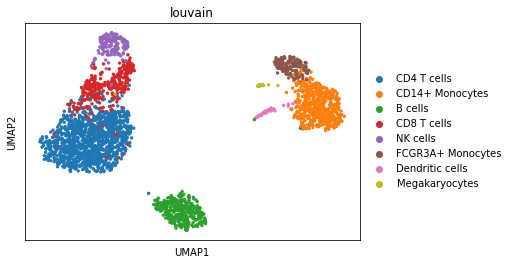

In [65]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref, n_neighbors=30, n_pcs=10)
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color='louvain')

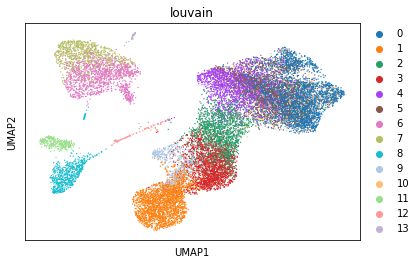

In [66]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='louvain')

In [67]:
adata.obs.rename(columns={"louvain": "louvain_old"}, inplace = True)
adata

AnnData object with n_obs × n_vars = 17475 × 1668
    obs: 'n_genes', 'n_counts', 'louvain_old'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [68]:
adata.var.set_index(adata.var.gene_name, inplace = True)

In [69]:
#subset the individual dataset to the same variable genes as in MNN-correct.
alldata = dict()
alldata['ctrl']=adata
alldata['ref']=adata_ref

#convert to list of AnnData objects
adatas = list(alldata.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

Found 1668 genes among all datasets
[[0.         0.90219864]
 [0.         0.        ]]
Processing datasets (0, 1)


In [70]:
# add in sample info
adata_ref.obs['sample']='pbmc3k'

In [71]:
# create a merged scanpy object and add in the scanorama 
adata_merged = alldata['ctrl'].concatenate(alldata['ref'], batch_key='sample', batch_categories=['ctrl','pbmc3k'])

embedding = np.concatenate([ad.obsm['X_scanorama'] for ad in adatas], axis=0)

adata_merged.obsm['Scanorama'] = embedding

/gpfs/space/home/ingvar/BioENV/lib/python3.8/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/gpfs/space/home/ingvar/BioENV/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [72]:
#run  umap.
sc.pp.neighbors(adata_merged, n_neighbors=30, n_pcs=10, use_rep = "Scanorama")
sc.tl.umap(adata_merged)

In [73]:
adata_merged

AnnData object with n_obs × n_vars = 20113 × 1668
    obs: 'n_genes', 'n_counts', 'louvain_old', 'percent_mito', 'louvain', 'sample'
    var: 'gene_name-ctrl', 'n_cells-ctrl', 'highly_variable-ctrl', 'means-ctrl', 'dispersions-ctrl', 'dispersions_norm-ctrl', 'mean-ctrl', 'std-ctrl', 'n_cells-pbmc3k'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_scanorama', 'Scanorama'
    obsp: 'distances', 'connectivities'

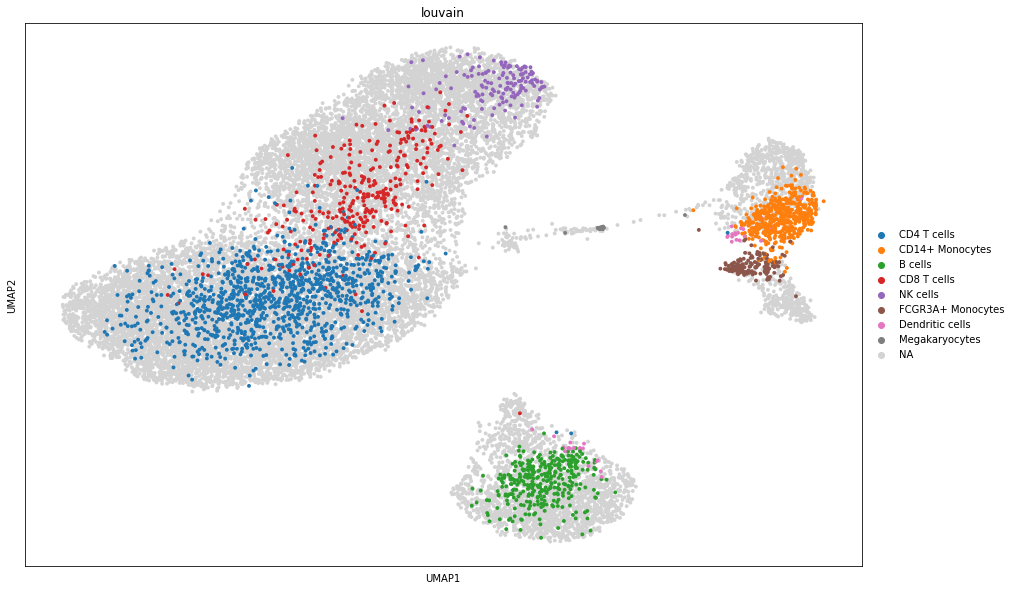

In [74]:
fig, ax = plt.subplots(figsize=(15, 10))
sc.pl.umap(adata_merged, color="louvain", ax=ax, size=120000/2000)

In [75]:
from sklearn.metrics.pairwise import cosine_distances

distances = 1 - cosine_distances(
    adata_merged[adata_merged.obs['sample'] == "pbmc3k"].obsm["Scanorama"],
    adata_merged[adata_merged.obs['sample'] == "ctrl"].obsm["Scanorama"],
)

In [76]:
def label_transfer(dist, labels, index):
    lab = pd.get_dummies(labels)
    class_prob = lab.to_numpy().T @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    # convert to df
    cp_df = pd.DataFrame(
        class_prob, columns=lab.columns
    )
    cp_df.index = index
    # classify as max score
    m = cp_df.idxmax(axis=1)
    
    return m

In [77]:
class_def = label_transfer(distances, adata_ref.obs.louvain, adata.obs.index)
# add to obs section of the original object
adata.obs['predicted'] = class_def

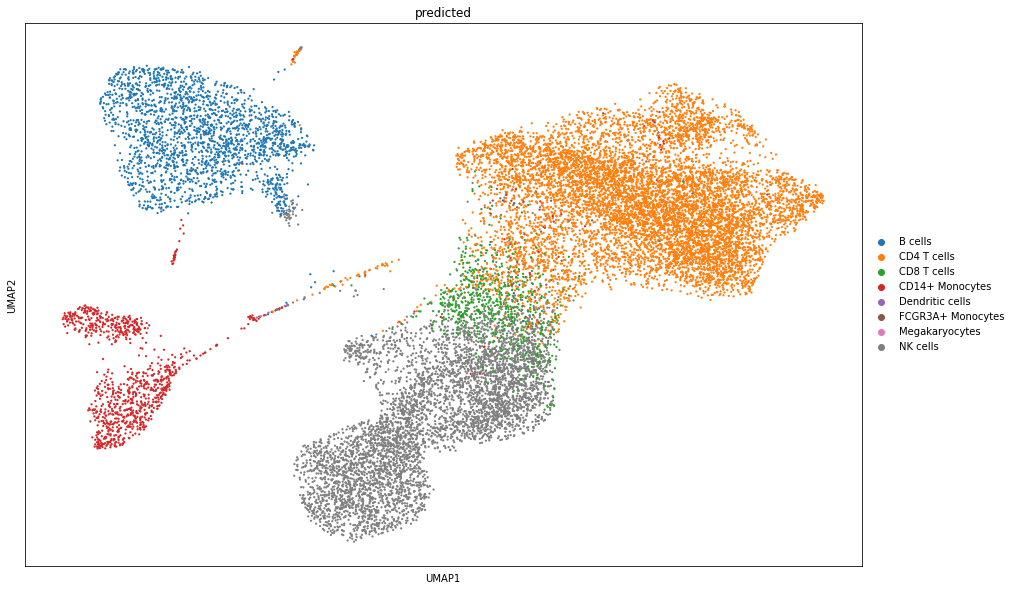

In [78]:
fig, ax = plt.subplots(figsize=(15, 10))
sc.pl.umap(adata, color="predicted", ax = ax, size=120000/6000)